In [30]:
import numpy as np
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
(training_images, training_labels), (testing_images, testing_labels) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [32]:
training_images

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [2]:
df_list = []
for file_name in glob.glob("../Data/Raw/Archive/*.txt"):
    df_temp = pd.read_csv(file_name, sep="\t")
    df_list.append(df_temp)
df = pd.concat(df_list, axis=0, ignore_index=True)

In [3]:
df

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...
19365,7153718@N04,11598838386_349a0d4849_o.jpg,2282,None,NaN,596,460,1472,1473,-75,0,30
19366,7153718@N04,11598166203_c70bb34c80_o.jpg,2283,None,NaN,1179,755,331,331,5,0,108
19367,7153718@N04,11598166203_c70bb34c80_o.jpg,2282,None,NaN,1201,1179,293,293,5,0,99
19368,7153718@N04,11598145163_733cb99713_o.jpg,2282,None,NaN,1027,946,408,408,-85,0,49


In [4]:
df = df.dropna()

In [5]:
df["age"].value_counts()

(25, 32)     4953
(0, 2)       2488
(38, 43)     2293
(4, 6)       2140
(8, 12)      2119
(15, 20)     1642
(60, 100)     867
(48, 53)      825
35            293
13            168
22            149
34            105
23             96
45             88
(27, 32)       77
55             76
36             56
(38, 42)       46
None           40
57             24
3              18
29             11
(38, 48)        6
58              5
2               3
(8, 23)         1
42              1
46              1
Name: age, dtype: int64

Age map to use for regression

In [7]:
df = df[df["age"] != "None"]

ages_map = {}
ages_keys = df["age"].value_counts().index
ages_values = []

for x in df["age"].value_counts().index:
    if x.startswith("("):
        x = x.split(", ")
        x[0] = x[0].replace("(","")
        x[1] = x[1].replace(")","")
        x[0] = int(x[0])
        x[1] = int(x[1])
        x = int((x[0]+x[1])/2)
        ages_values.append(x)
    else:
        ages_values.append(int(x))

In [8]:
for key, value in zip(ages_keys, ages_values):
    ages_map[key] = value

In [9]:
df["age"] = df["age"].map(ages_map)

28    4953
1     2488
40    2339
5     2140
10    2119
17    1642
80     867
50     825
35     293
13     168
22     149
34     105
23      96
45      88
29      88
55      76
36      56
57      24
3       18
43       6
58       5
2        3
15       1
42       1
46       1
Name: age, dtype: int64

In [10]:
df["gender"].value_counts()

f    9332
m    8120
u    1099
Name: gender, dtype: int64

In [11]:
df = df[df["gender"] != "u"]
df["gender"] = df["gender"].apply(lambda x: 1 if x == "m" else 0).astype(int)

In [13]:
df["face_id"] = df["face_id"].astype(str)
df["path"] = df["user_id"]+"/coarse_tilt_aligned_face."+df["face_id"]+"."+df["original_image"]

In [15]:
X = df["path"]
y_age = df["age"]
y_gender = df["gender"]

In [16]:
X_train, X_test, y_train_age, y_test_age = train_test_split(X, y_age, test_size = 0.22, random_state = 22)
X_train, X_test, y_train_gender, y_test_gender = train_test_split(X, y_gender, test_size = 0.22, random_state = 22)

Image greyscaled, downscaled, size adjusted and transformed.

In [75]:
def image_preprocess(path):
    img = tf.io.read_file(np.array("../Data/Raw/Archive/Faces/"+path).ravel()[0])
    img = tf.image.decode_jpeg(img, channels = 1, ratio = 2)
    img = tf.image.resize(img, [32,32])
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

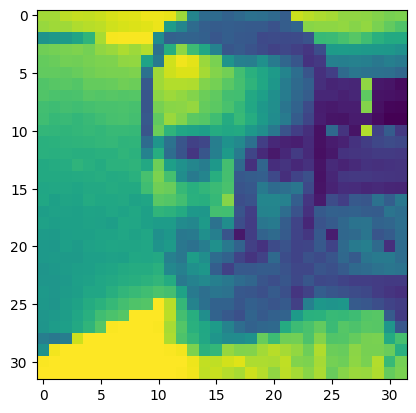

In [76]:
plt.imshow(image_preprocess(df["path"][22]))

In [78]:
X_train_images = np.array([image_preprocess(path) for path in X_train])
X_test_images = np.array([image_preprocess(path) for path in X_test])

In [79]:
model = Sequential()
model.add(Conv2D(32,(3,3), activation = "relu", input_shape = (32,32,1)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3), activation = "relu"))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3), activation = "relu"))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dense(1, activation = "relu"))
model.compile(optimizer = "adam",
              loss = "mse",
              metrics = ["mae", "mse", "mape"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 64)        

In [74]:
y_test_age

8603      1
6011     40
8003     28
8088     17
14079    40
         ..
13815    80
16119     1
9612      5
5619      5
9162     28
Name: age, Length: 3840, dtype: int64

In [55]:
early_stop = EarlyStopping(patience=5)

checkpoint_path = '../Models/Age_NN2.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=False,
    verbose=1
)

In [81]:
history = model.fit(
    X_train_images, y_train_age,
    epochs=50,
    validation_data = (X_test_images, y_test_age),
    batch_size=20,
    verbose=2,
    callbacks=[early_stop,checkpoint]
)

Epoch 1/50

Epoch 1: saving model to ../Models\Age_NN2.hdf5
681/681 - 20s - loss: 74.6042 - mae: 6.4953 - mse: 74.6042 - mape: 65.5607 - val_loss: 171.9528 - val_mae: 9.1791 - val_mse: 171.9528 - val_mape: 94.6265 - 20s/epoch - 30ms/step
Epoch 2/50

Epoch 2: saving model to ../Models\Age_NN2.hdf5
681/681 - 18s - loss: 69.7654 - mae: 6.2983 - mse: 69.7654 - mape: 64.0919 - val_loss: 185.4160 - val_mae: 9.6294 - val_mse: 185.4160 - val_mape: 101.0777 - 18s/epoch - 27ms/step
Epoch 3/50

Epoch 3: saving model to ../Models\Age_NN2.hdf5
681/681 - 20s - loss: 65.4343 - mae: 6.1378 - mse: 65.4343 - mape: 62.9369 - val_loss: 176.5670 - val_mae: 9.2324 - val_mse: 176.5670 - val_mape: 90.4712 - 20s/epoch - 30ms/step
Epoch 4/50

Epoch 4: saving model to ../Models\Age_NN2.hdf5
681/681 - 20s - loss: 60.2477 - mae: 5.8932 - mse: 60.2477 - mape: 60.4929 - val_loss: 172.5895 - val_mae: 9.0566 - val_mse: 172.5895 - val_mape: 86.0807 - 20s/epoch - 29ms/step
Epoch 5/50

Epoch 5: saving model to ../Models\